In [11]:
XLA_PYTHON_CLIENT_MEM_FRACTION=.5

#import wandb

import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random, jit

from scipy.special import comb

from jax.numpy.linalg import det
import jax

import matplotlib
#matplotlib.rcParams.update({'font.size': 12})


In [28]:
def getfun(X0,X1,kmax):
    P=jnp.shape(X0)[0]
    Q=jnp.shape(X0)[1]
    
    idcs = jnp.tile(jnp.arange(P)[:, None], (1, Q))

    def compute_m_one(i):
        S = P * jnp.where(idcs == i, X0, 0)
        X0sub = jnp.where(idcs >= i, X0, 0)
        X1sub = jnp.where(idcs >= i, X1, 0)
        m_one = []
        for k in jnp.arange(kmax-1) + 1:
            S = ((k + 1) ** 2) / ((P - k) * (Q - k)) * cumsum2(cumsum2(S, axis=0) * X1sub, axis=1) * X0sub
            m_one.append(jnp.sum((jnp.sum(S, axis=0) / P) * X1[i, :]) / Q)
        return jnp.array(m_one)
    
    return compute_m_one


def cumsum2(x,axis=0):
    return np.cumsum(x,axis=axis)-x

def momest2(X0,X1,kmax=5,reps=3):
    P=jnp.shape(X0)[0]
    Q=jnp.shape(X0)[1]
    
    
    key = random.PRNGKey(0)
    Mvs2=[]
    for u in range(reps):
        key1,key2,key = random.split(key,3)
        X0_new=random.permutation(key2,random.permutation(key1, X0, axis=0),axis=1)
        X1_new=random.permutation(key2,random.permutation(key1, X1, axis=0),axis=1)
        compute_m_one = getfun(X0_new,X1_new,kmax)
        # Vectorize the computation across the first dimension
        compute_m_one_vmap = jax.vmap(compute_m_one, in_axes=(0,))
        Ms = compute_m_one_vmap(jnp.arange(P))
        print(Ms)
        Ms0 = jnp.sum(Ms, axis=0) / P
        Mvs2.append(np.squeeze(Ms0))    
    mv2=np.mean(np.array(Mvs2),axis=0)
    
    return mv2

np.random.seed(0)
X=np.abs(np.random.randn(10,7))
momest2(X,X,kmax=3,reps=1)



[[1.575982   1.3008965 ]
 [0.588777   0.31853974]
 [0.7412049  0.34818205]
 [0.49492583 0.3028534 ]
 [0.15201908 0.07962552]
 [0.45383716 0.05522398]
 [0.13055404 0.00999665]
 [0.08616586 0.00366523]
 [0.14514342 0.        ]
 [0.         0.        ]]


array([0.43686095, 0.24189833], dtype=float32)

In [12]:
def getfun(X0,X1,kmax):
    P=jnp.shape(X0)[0]
    Q=jnp.shape(X0)[1]
    
    idcs = jnp.tile(jnp.arange(P)[:, None], (1, Q))

    def compute_m_one(i):
        S = P * jnp.where(idcs == i, X0, 0)
        X0sub = jnp.where(idcs >= i, X0, 0)
        X1sub = jnp.where(idcs >= i, X1, 0)
        m_one = []
        for k in jnp.arange(kmax-1) + 1:
            S = ((k + 1) ** 2) / ((P - k) * (Q - k)) * cumsum2(cumsum2(S, axis=0) * X1sub, axis=1) * X0sub
            m_one.append(jnp.sum((jnp.sum(S, axis=0) / P) * X1[i, :]) / Q)
        return jnp.array(m_one)
    
    return compute_m_one


def cumsum2(x,axis=0):
    return np.cumsum(x,axis=axis)-x

def momest(X0,X1,kmax=5,reps=3):
    P=jnp.shape(X0)[0]
    Q=jnp.shape(X0)[1]
    
    
    key = random.PRNGKey(0)
    Mvs2=[]
    for u in range(reps):
        key1,key2,key = random.split(key,3)
        X0_new=random.permutation(key2,random.permutation(key1, X0, axis=0),axis=1)
        X1_new=random.permutation(key2,random.permutation(key1, X1, axis=0),axis=1)
        compute_m_one = getfun(X0_new,X1_new,kmax)
        # Vectorize the computation across the first dimension
        compute_m_one_vmap = jax.vmap(compute_m_one, in_axes=(0,))
        Ms = compute_m_one_vmap(jnp.arange(P))
        Ms0 = jnp.sum(Ms, axis=0) / P
        Mvs2.append(np.squeeze(Ms0))    
    mv2=np.mean(np.array(Mvs2),axis=0)
    
    return mv2

def compute_RBF_m(k, Sigma, Sigma_x):
    # Identity matrix of the same shape as Sigma
    I = jnp.eye(Sigma.shape[0])
    
    # Inverse of Sigma
    Sigma_inv = jnp.linalg.inv(Sigma)
    
    # Initialize the product
    prod_determinants = 1.0

    # Loop over q from 0 to k-1
    for q in range(k):
        # Calculate the exponent term
        #exponent_term = 2 * (1 - jnp.exp(2j * jnp.pi * q / k))
        exponent_term = 2 * (1 - jnp.cos(2 * jnp.pi * q / k))

        # Compute the matrix inside the determinant
        matrix_term = exponent_term * Sigma_inv @ Sigma_x + I
        
        # Calculate the determinant
        det_value = det(matrix_term)
        
        # Multiply to the product of determinants
        prod_determinants *= det_value
    
    # Compute m(k) as the product raised to the power of -1/2
    m_k = prod_determinants ** (-0.5)
    
    return m_k

def getKong(Xs1,Xs2,k):
    P=jnp.shape(Xs1)[0]
    Q=jnp.shape(Xs1)[1]
    
    Kc = jnp.matmul(Xs1,Xs2.T)/Q
    KongEst = jnp.trace(jnp.matmul(jnp.linalg.matrix_power(jnp.triu(Kc, 1),int(k-1)),Kc))/comb(P,k)
    return KongEst


def detRBFData(d,sigmax,sigma,P,Q,key,eps0=0,eps1=0):
    sqrt2=jnp.sqrt(2)
    key1,key2,key3, key = random.split(key,4)
    
    #X=np.random.randn(P,d)*sigmax
    X=random.normal(key1, (P, d))*sigmax
    W=random.normal(key2, (d, Q))/sigma

    p=random.uniform(key3,(Q,),minval=-jnp.pi/2,maxval=jnp.pi/2)

    Phi=sqrt2*jnp.cos(jnp.matmul(X,W)-p[None,:])
    
    if eps0!=0:
        key1,key2,key = random.split(key,3)
        Psi1=random.normal(key1, (P, Q))*eps0
        Psi2=random.normal(key2, (P, Q))*eps0
    else:
        Psi1=0
        Psi2=0
    
    if eps1!=0:
        key1,key2,key = random.split(key,3)
        Psi1a=random.normal(key1, (P, Q))*eps1
        Psi2a=random.normal(key2, (P, Q))*eps1
    else:
        Psi1a=0
        Psi2a=0
    
    Theta1=Phi+Psi1*Phi+Psi1a
    Theta2=Phi+Psi2*Phi+Psi2a
    return Theta1,Theta2,key

def getKsTerms(Xs1,Xs2,M=jnp.inf,F=jnp.inf):
    P=jnp.shape(Xs1)[0]
    Q=jnp.shape(Xs1)[1]
    
    Phr=(P-1)/(M-1)
    Qhr=(Q-1)/(F-1)
    Pr=P/M
    Qr=Q/F
    
    #if False:
    if P<Q:
        Kv=1/Q*jnp.matmul(Xs1,Xs2.T)
        nTrKs_min2=jnp.mean(jnp.diag(jnp.linalg.matrix_power(Kv,2)/P))
        #nTrKs_min2=jnp.mean(jnp.square(1/Q*jnp.matmul(Xs1,Xs2.T)))
    else:
        Kv=1/P*jnp.matmul(Xs1.T,Xs2)
        nTrKs_min2=jnp.mean(jnp.diag(jnp.linalg.matrix_power(Kv,2)/Q))
        #nTrKs_min2=jnp.mean(jnp.square(1/P*jnp.matmul(Xs1.T,Xs2)))
            
    Term2=-(1-Phr)/P * jnp.mean(jnp.square(jnp.mean(Xs1*Xs2,axis=1)))
    Term3=-(1-Qhr)/Q * jnp.mean(jnp.square(jnp.mean(Xs1*Xs2,axis=0)))
    Term4=((1-Phr)*(1-Qhr))/(P*Q) * jnp.mean(jnp.power(Xs1*Xs2,2))
        
    v =  Term2 + Term3 + Term4
    
    nsTrKs = jnp.square(jnp.mean(Xs1*Xs2))
    
    # if M and F are infinite, or even if M and F are finite:
    denom =  (nTrKs_min2 +v)
    numer =  (nsTrKs +v)
    # There are some scaling differences, but all that matters is numer/denom, which cancels out the scaling factors.
    
    gammas=nsTrKs/nTrKs_min2
    gamma_mp1=gammas*P/(P-gammas)
    gamma_mp2=gammas*Q/(Q-gammas)
    
    return numer , denom , gammas, gamma_mp1,gamma_mp2



In [9]:


def run_exp(P,Q,d,sigma,sigmax,eps_a,eps_m,kmax,key,noAlt,reps=10):
    X0,X1,key = detRBFData(d,sigmax,sigma,P,Q,key,eps0=eps_m,eps1=eps_a)
    if noAlt:
        X1=X0
    mds = momest(X0,X1,kmax=kmax,reps=reps)

    s,_=jnp.linalg.eigh(jnp.matmul(X0,X1.T)/Q)
    mns=[]
    mk0s=[]
    mk1s=[]
    for k in jnp.arange(1,kmax)+1:
        mns.append(jnp.sum(jnp.power(s/P,k)))
        mk0s.append(getKong(X0,X1,k))
        mk1s.append(getKong(X0.T,X1.T,k))
        
    numer , denom ,gammas, _,_ = getKsTerms(X0,X1,M=jnp.inf,F=jnp.inf)
    
    return mds.tolist(),mns,mk0s,mk1s,numer,denom,gammas, key
            
def run_repeats(P,Q,d,sigma,sigmax,eps_a,eps_m,kmax,seed,numit,noAlt,reps=10):
    key = random.PRNGKey(seed)
    Mss=[]
    Mk0s=[]
    Mk1s=[]
    Mns=[]
    numers=[]
    denoms=[]
    gammass=[]
    for it in range(numit):
        print('\r{:.2f}'.format((it+1)/numit),end='')
        mds,mns,mk0s,mk1s,numer,denom,gammas,key=run_exp(P,Q,d,sigma,sigmax,eps_a,eps_m,kmax,key,noAlt,reps=reps)
        
        #for md,mn,mk0,mk1 in zip(mds,mns,mk0s,mk1s):
            #print(md)
            #wandb.log({"double": md, "single_row": mk0, "single_col": mk1, "naive":mn})
            
        #wandb.finish()

        Mss.append(mds)
        Mns.append(mns)
        Mk0s.append(mk0s)
        Mk1s.append(mk1s)
        
        gammass.append(gammas)
        numers.append(numer)
        denoms.append(denom)
    Mss=np.array(Mss).T
    Mns=np.array(Mns).T
    Mk0s=np.array(Mk0s).T
    Mk1s=np.array(Mk1s).T
    
    dimest=np.mean(numers)/np.mean(denoms)
    return Mss,Mns,Mk0s,Mk1s,dimest,np.mean(gammass)


kmax=7
seed=0 
numit=1000
sigmax=1


P=300
Q=600
sigma=0.5
d=5
eps_a=0
eps_m=0
noAlt=True

Mss,Mns,Mk0s,Mk1s,dimest,gams = run_repeats(P,Q,d,sigma,sigmax,eps_a,eps_m,kmax,seed,numit,noAlt)

Sigma_x=jnp.eye(d)*sigmax**2
Sigma=jnp.eye(d)*sigma**2

Mts=[]
for k in np.arange(1,kmax)+1:
    Mts.append(compute_RBF_m(k, Sigma, Sigma_x))

#np.savez('./sweep_data/'+'s_d{}_s{}_p{}_q{}_a{}_m{}_n{}.npz'.format(d,sigma,P,Q,eps_a,eps_m,noa), Mss=Mss,Mns=Mns,Mk0s=Mk0s,Mk1s=Mk1s,Mts=Mts,dimest=dimest,gams=gams,kmax=kmax,seed=seed,numit=numit,sigmax=sigmax)


Mts=np.array(Mts)



1.00

In [302]:

#Mss=np.power(Mss,1/np.arange(2,kmax+1)[:,None])
#Mns=np.power(Mns,1/np.arange(2,kmax+1)[:,None])
#Mk0s=np.power(Mk0s,1/np.arange(2,kmax+1)[:,None])
#Mk1s=np.power(Mk1s,1/np.arange(2,kmax+1)[:,None])
#Mts=np.power(Mts,1/np.arange(2,kmax+1))



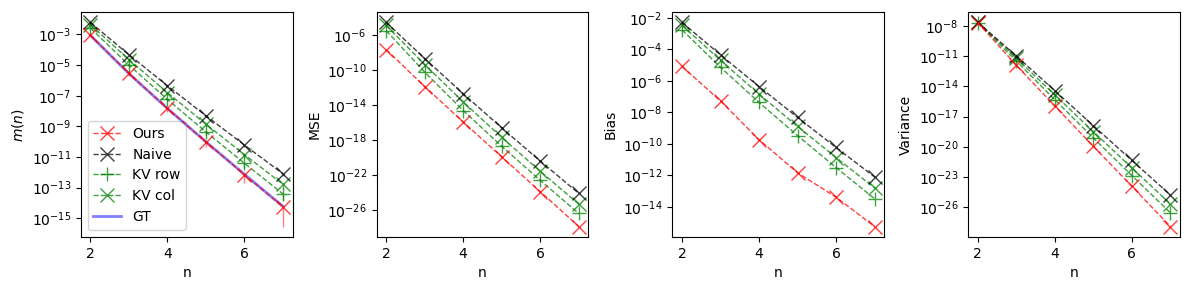

In [4]:
ylog=True
ls='--'
eb_alpha=0.5

fig,ax=plt.subplots(1,4,figsize=(12,3))
#ax.plot(Ps,gims,c='k',label='theory')

xoi=np.arange(kmax-1)+2
qoi=Mss
colorv='r'
zo=10
yval=np.nanmedian(qoi,axis=1)
lower_error=np.nanquantile(qoi,axis=1,q=0.25)
upper_error=np.nanquantile(qoi,axis=1,q=0.75)
asymmetric_error = [yval-lower_error, upper_error-yval]
ax[0].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=eb_alpha,lw=1,zorder=zo)#, fmt='o')
yval=np.nanmean(qoi,axis=1)
ax[0].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Ours',zorder=zo*100)#, fmt='o')


qoi=Mns
colorv='k'
zo=5
yval=np.nanmedian(qoi,axis=1)
lower_error=np.nanquantile(qoi,axis=1,q=0.25)
upper_error=np.nanquantile(qoi,axis=1,q=0.75)
asymmetric_error = [yval-lower_error, upper_error-yval]
ax[0].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=eb_alpha,lw=1,zorder=zo)#, fmt='o')
yval=np.nanmean(qoi,axis=1)
ax[0].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Naive',zorder=zo*100)#, fmt='o')


qoi=Mk0s
colorv='g'
zo=1
yval=np.nanmedian(qoi,axis=1)
lower_error=np.nanquantile(qoi,axis=1,q=0.25)
upper_error=np.nanquantile(qoi,axis=1,q=0.75)
asymmetric_error = [yval-lower_error, upper_error-yval]
ax[0].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=eb_alpha,lw=1,zorder=zo)#, fmt='o')
yval=np.nanmean(qoi,axis=1)
ax[0].plot(xoi, yval,c=colorv,marker='+',ls=ls,alpha=0.75,ms=10,lw=1,label=r'KV row',zorder=zo*100)#, fmt='o')



qoi=Mk1s
colorv='g'
zo=1
yval=np.nanmedian(qoi,axis=1)
lower_error=np.nanquantile(qoi,axis=1,q=0.25)
upper_error=np.nanquantile(qoi,axis=1,q=0.75)
asymmetric_error = [yval-lower_error, upper_error-yval]
ax[0].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=eb_alpha,lw=1,zorder=zo)#, fmt='o')
yval=np.nanmean(qoi,axis=1)
ax[0].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'KV col',zorder=zo*100)#, fmt='o')

zo=-1
ax[0].plot(xoi,np.array(Mts),c='b',lw=2,alpha=0.5,label='GT',zorder=zo)

#ax.set_xscale('log')
ax[0].set_xlabel('n')
ax[0].set_ylabel(r'$m(n)$')
#ax.set_title('N={}, Q={}'.format(N,Q),fontsize=11)



gt=np.array(Mts)

#fig,ax=plt.subplots(1,3,figsize=(12,4))
#ax.plot(Ps,gims,c='k',label='theory')

xoi=np.arange(kmax-1)+2
qoi=Mss
yval=np.nanmean(np.square(gt[:,None]-qoi),axis=1)
colorv='r'
zo=10
ax[1].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Ours',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mns
yval=np.nanmean(np.square(gt[:,None]-qoi),axis=1)
colorv='k'
zo=5
ax[1].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Naive',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk0s
yval=np.nanmean(np.square(gt[:,None]-qoi),axis=1)
colorv='g'
zo=1
ax[1].plot(xoi, yval,c=colorv,marker='+',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Kong row',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk1s
yval=np.nanmean(np.square(gt[:,None]-qoi),axis=1)
colorv='g'
zo=1
ax[1].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Kong col',zorder=zo*100)#, fmt='o')



#ax.set_xscale('log')
ax[1].set_xlabel('n')
ax[1].set_ylabel('MSE')
#ax[1].legend(fontsize=11)
#ax.set_title('N={}, Q={}'.format(N,Q),fontsize=11)




xoi=np.arange(kmax-1)+2
qoi=Mss
yval=np.abs(gt-np.nanmean(qoi,axis=1))
colorv='r'
zo=10
ax[2].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Ours',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mns
yval=np.abs(gt-np.nanmean(qoi,axis=1))
colorv='k'
zo=5
ax[2].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Naive',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk0s
yval=np.abs(gt-np.nanmean(qoi,axis=1))
colorv='g'
zo=1
ax[2].plot(xoi, yval,c=colorv,marker='+',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Kong row',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk1s
yval=np.abs(gt-np.nanmean(qoi,axis=1))
colorv='g'
zo=1
ax[2].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Kong col',zorder=zo*100)#, fmt='o')

#ax.set_xscale('log')
ax[2].set_xlabel('n')
ax[2].set_ylabel('Bias')
#ax[1].legend(fontsize=11)
#ax.set_title('N={}, Q={}'.format(N,Q),fontsize=11)



#ax.plot(Ps,gims,c='k',label='theory')

xoi=np.arange(kmax-1)+2
qoi=Mss
yval=np.square(np.nanstd(qoi,axis=1))
colorv='r'
zo=10
ax[3].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Ours',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mns
yval=np.square(np.nanstd(qoi,axis=1))
colorv='k'
zo=5
ax[3].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Naive',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk0s
yval=np.square(np.nanstd(qoi,axis=1))
colorv='g'
zo=1
ax[3].plot(xoi, yval,c=colorv,marker='+',ls=ls,alpha=0.75,ms=10,lw=1,label=r'KV row',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk1s
yval=np.square(np.nanstd(qoi,axis=1))
colorv='g'
zo=1
ax[3].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'KV col',zorder=zo*100)#, fmt='o')

#ax.set_xscale('log')
ax[3].set_xlabel('n')
ax[3].set_ylabel('Variance')
#ax[2].legend(fontsize=11)
#ax.set_title('N={}, Q={}'.format(N,Q),fontsize=11)


if ylog:
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[2].set_yscale('log')
    ax[3].set_yscale('log')


ax[0].legend(fontsize=10).set_zorder(-100000)
    
fig.tight_layout()

#fig

# for the bias: try \hat{m}(n)-GT with the error bars.



/tmp/ipykernel_2258986/1769207981.py:1: RuntimeWarning: invalid value encountered in power
  Mss_p=np.power(Mss,1/np.arange(2,kmax+1)[:,None])


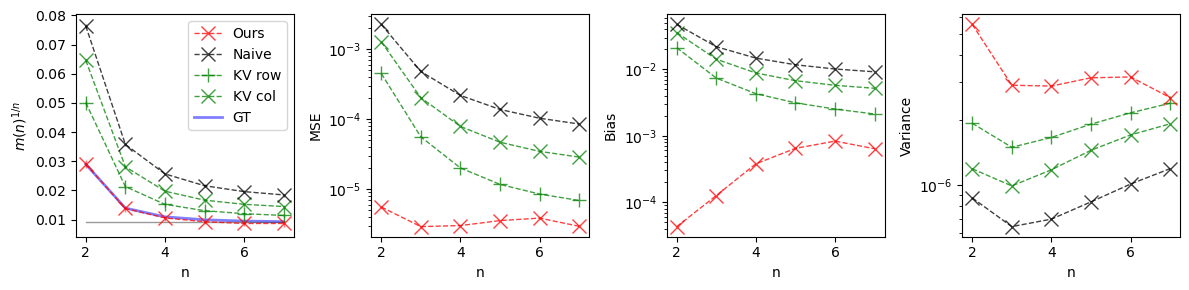

In [5]:

Mss_p=np.power(Mss,1/np.arange(2,kmax+1)[:,None])
Mns_p=np.power(Mns,1/np.arange(2,kmax+1)[:,None])
Mk0s_p=np.power(Mk0s,1/np.arange(2,kmax+1)[:,None])
Mk1s_p=np.power(Mk1s,1/np.arange(2,kmax+1)[:,None])
Mts_p=np.power(Mts,1/np.arange(2,kmax+1))

ylog=True
ls='--'
eb_alpha=0.5

fig,ax=plt.subplots(1,4,figsize=(12,3))
#ax.plot(Ps,gims,c='k',label='theory')

xoi=np.arange(kmax-1)+2
qoi=Mss_p
colorv='r'
zo=10
yval=np.nanmedian(qoi,axis=1)
lower_error=np.nanquantile(qoi,axis=1,q=0.25)
upper_error=np.nanquantile(qoi,axis=1,q=0.75)
asymmetric_error = [yval-lower_error, upper_error-yval]
ax[0].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=eb_alpha,lw=1,zorder=zo)#, fmt='o')
yval=np.nanmean(qoi,axis=1)
ax[0].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Ours',zorder=zo*100)#, fmt='o')


qoi=Mns_p
colorv='k'
zo=5
yval=np.nanmedian(qoi,axis=1)
lower_error=np.nanquantile(qoi,axis=1,q=0.25)
upper_error=np.nanquantile(qoi,axis=1,q=0.75)
asymmetric_error = [yval-lower_error, upper_error-yval]
ax[0].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=eb_alpha,lw=1,zorder=zo)#, fmt='o')
yval=np.nanmean(qoi,axis=1)
ax[0].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Naive',zorder=zo*100)#, fmt='o')


qoi=Mk0s_p
colorv='g'
zo=1
yval=np.nanmedian(qoi,axis=1)
lower_error=np.nanquantile(qoi,axis=1,q=0.25)
upper_error=np.nanquantile(qoi,axis=1,q=0.75)
asymmetric_error = [yval-lower_error, upper_error-yval]
ax[0].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=eb_alpha,lw=1,zorder=zo)#, fmt='o')
yval=np.nanmean(qoi,axis=1)
ax[0].plot(xoi, yval,c=colorv,marker='+',ls=ls,alpha=0.75,ms=10,lw=1,label=r'KV row',zorder=zo*100)#, fmt='o')



qoi=Mk1s_p
colorv='g'
zo=1
yval=np.nanmedian(qoi,axis=1)
lower_error=np.nanquantile(qoi,axis=1,q=0.25)
upper_error=np.nanquantile(qoi,axis=1,q=0.75)
asymmetric_error = [yval-lower_error, upper_error-yval]
ax[0].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=eb_alpha,lw=1,zorder=zo)#, fmt='o')
yval=np.nanmean(qoi,axis=1)
ax[0].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'KV col',zorder=zo*100)#, fmt='o')

zo=-1
ax[0].plot(xoi,np.array(Mts_p),c='b',lw=2,alpha=0.5,label='GT',zorder=zo)

#ax.set_xscale('log')
ax[0].set_xlabel('n')
ax[0].set_ylabel(r'$m(n)^{1/n}$')
#ax.set_title('N={}, Q={}'.format(N,Q),fontsize=11)



gt=np.array(Mts_p)

#fig,ax=plt.subplots(1,3,figsize=(12,4))
#ax.plot(Ps,gims,c='k',label='theory')

xoi=np.arange(kmax-1)+2
qoi=Mss_p
yval=np.nanmean(np.square(gt[:,None]-qoi),axis=1)
colorv='r'
zo=10
ax[1].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Ours',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mns_p
yval=np.nanmean(np.square(gt[:,None]-qoi),axis=1)
colorv='k'
zo=5
ax[1].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Naive',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk0s_p
yval=np.nanmean(np.square(gt[:,None]-qoi),axis=1)
colorv='g'
zo=1
ax[1].plot(xoi, yval,c=colorv,marker='+',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Kong row',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk1s_p
yval=np.nanmean(np.square(gt[:,None]-qoi),axis=1)
colorv='g'
zo=1
ax[1].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Kong col',zorder=zo*100)#, fmt='o')



#ax.set_xscale('log')
ax[1].set_xlabel('n')
ax[1].set_ylabel('MSE')
#ax[1].legend(fontsize=11)
#ax.set_title('N={}, Q={}'.format(N,Q),fontsize=11)




xoi=np.arange(kmax-1)+2
qoi=Mss_p
yval=np.abs(gt-np.nanmean(qoi,axis=1))
colorv='r'
zo=10
ax[2].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Ours',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mns_p
yval=np.abs(gt-np.nanmean(qoi,axis=1))
colorv='k'
zo=5
ax[2].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Naive',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk0s_p
yval=np.abs(gt-np.nanmean(qoi,axis=1))
colorv='g'
zo=1
ax[2].plot(xoi, yval,c=colorv,marker='+',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Kong row',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk1s_p
yval=np.abs(gt-np.nanmean(qoi,axis=1))
colorv='g'
zo=1
ax[2].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Kong col',zorder=zo*100)#, fmt='o')

#ax.set_xscale('log')
ax[2].set_xlabel('n')
ax[2].set_ylabel('Bias')
#ax[1].legend(fontsize=11)
#ax.set_title('N={}, Q={}'.format(N,Q),fontsize=11)



#ax.plot(Ps,gims,c='k',label='theory')

xoi=np.arange(kmax-1)+2
qoi=Mss_p
yval=np.square(np.nanstd(qoi,axis=1))
colorv='r'
zo=10
ax[3].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Ours',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mns_p
yval=np.square(np.nanstd(qoi,axis=1))
colorv='k'
zo=5
ax[3].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Naive',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk0s_p
yval=np.square(np.nanstd(qoi,axis=1))
colorv='g'
zo=1
ax[3].plot(xoi, yval,c=colorv,marker='+',ls=ls,alpha=0.75,ms=10,lw=1,label=r'KV row',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk1s_p
yval=np.square(np.nanstd(qoi,axis=1))
colorv='g'
zo=1
ax[3].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'KV col',zorder=zo*100)#, fmt='o')

#ax.set_xscale('log')
ax[3].set_xlabel('n')
ax[3].set_ylabel('Variance')
#ax[2].legend(fontsize=11)
#ax.set_title('N={}, Q={}'.format(N,Q),fontsize=11)


if ylog:
    #ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[2].set_yscale('log')
    ax[3].set_yscale('log')


ax[0].legend(fontsize=10).set_zorder(-100000)
    
    
eta=np.square(sigmax/sigma)
ax[0].plot([2,kmax],np.power((-1+np.sqrt(1+4*eta))/(2*eta),d) *np.ones(2),'k-',alpha=0.4,lw=1)


fig.tight_layout()

#fig



10
1.00
16
1.00
27
1.00
46
1.00
77
1.00
129
1.00
215
1.00
359
1.00
599
1.00
1000
1.00
10
1.00
16
1.00
27
1.00
46
1.00
77
1.00
129
1.00
215
1.00
359
1.00
599
1.00
1000
1.00
10
1.00
16
1.00
27
1.00
46
1.00
77
1.00
129
1.00
215
1.00
359
1.00
599
1.00
1000
1.00
10
1.00
16
1.00
27
1.00
46
1.00
77
1.00
129
1.00
215
1.00
359
1.00
599
1.00
1000
1.00

In [6]:
numit=2000

seed=2

P=300 #300
#Q=600
#Qs=np.power(10,np.linspace(np.log10(50),np.log10(1000),10)).astype(int)
Qs=np.power(2,np.arange(5,11))
#Qs=np.power(10,np.linspace(np.log10(300),np.log10(4000),5)).astype(int)

Mss_s=[]
Mns_s=[]
Mk0s_s=[]
Mk1s_s=[]
for Q in Qs:
    print('')
    print(Q)
    Mss,Mns,Mk0s,Mk1s,dimest,gams = run_repeats(P,Q,d,sigma,sigmax,eps_a,eps_m,kmax,seed,numit,noAlt,reps=1)

    Mss_s.append(Mss)
    Mns_s.append(Mns)
    Mk0s_s.append(Mk0s)
    Mk1s_s.append(Mk1s)

Mss_s=np.array(Mss_s)
Mns_s=np.array(Mns_s)
Mk0s_s=np.array(Mk0s_s)
Mk1s_s=np.array(Mk1s_s)

Sigma_x=jnp.eye(d)*sigmax**2
Sigma=jnp.eye(d)*sigma**2

Mts=[]
for k in np.arange(1,kmax)+1:
    Mts.append(compute_RBF_m(k, Sigma, Sigma_x))    
Mts=np.array(Mts)





32
1.00
64
1.00
128
1.00
256
1.00
512
1.00
1024
1.00

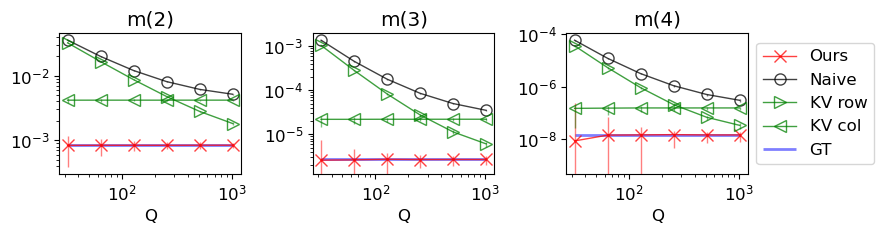

In [110]:

fig,ax=plt.subplots(1,3,figsize=(9,2.5))

#for i in range(np.shape(Mss_s)[1]):
for i in range(3):
    #ax.plot(Qs,Mss_s[:,i,:])
    xoi=Qs
    
    qoi=Mss_s[:,i,:]#-Mts[i]
    colorv='r'
    zo=10
    yval=np.nanmedian(qoi,axis=1)
    lower_error=np.nanquantile(qoi,axis=1,q=0.25)
    upper_error=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower_error, upper_error-yval]
    ax[i].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=0.5,lw=1,zorder=zo)#, fmt='o')
    yval=np.nanmean(qoi,axis=1)
    ax[i].plot(xoi, yval,c=colorv,marker='x',fillstyle='none',ls='-',alpha=0.75,ms=8,lw=1,label=r'Ours',zorder=zo*100)#, fmt='o')

    
    qoi=Mns_s[:,i,:]#-Mts[i]
    colorv='k'
    zo=10
    yval=np.nanmedian(qoi,axis=1)
    lower_error=np.nanquantile(qoi,axis=1,q=0.25)
    upper_error=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower_error, upper_error-yval]
    ax[i].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=0.5,lw=1,zorder=zo)#, fmt='o')
    yval=np.nanmean(qoi,axis=1)
    ax[i].plot(xoi, yval,c=colorv,marker='o',fillstyle='none',ls='-',alpha=0.75,ms=8,lw=1,label=r'Naive',zorder=zo*100)#, fmt='o')

    qoi=Mk0s_s[:,i,:]#-Mts[i]
    colorv='g'
    zo=10
    yval=np.nanmedian(qoi,axis=1)
    lower_error=np.nanquantile(qoi,axis=1,q=0.25)
    upper_error=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower_error, upper_error-yval]
    ax[i].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=0.5,lw=1,zorder=zo)#, fmt='o')
    yval=np.nanmean(qoi,axis=1)
    ax[i].plot(xoi, yval,c=colorv,marker='>',fillstyle='none',ls='-',alpha=0.75,ms=8,lw=1,label=r'KV row',zorder=zo*100)#, fmt='o')

    qoi=Mk1s_s[:,i,:]#-Mts[i]
    colorv='g'
    zo=10
    yval=np.nanmedian(qoi,axis=1)
    lower_error=np.nanquantile(qoi,axis=1,q=0.25)
    upper_error=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower_error, upper_error-yval]
    ax[i].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=0.5,lw=1,zorder=zo)#, fmt='o')
    yval=np.nanmean(qoi,axis=1)
    ax[i].plot(xoi, yval,c=colorv,marker='<',fillstyle='none',ls='-',alpha=0.75,ms=8,lw=1,label=r'KV col',zorder=zo*100)#, fmt='o')
  
    
    ax[i].hlines(Mts[i],np.min(Qs),np.max(Qs),color='b',alpha=0.5,lw=2,label='GT')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('Q')
    ax[i].set_title('m({})'.format(i+2))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()



In [7]:
numit=2000

seed=2

Q=600 #300
#Q=600
#Qs=np.power(10,np.linspace(np.log10(50),np.log10(1000),10)).astype(int)
Ps=np.power(2,np.arange(5,11))
#Qs=np.power(10,np.linspace(np.log10(300),np.log10(4000),5)).astype(int)

Mss2_s=[]
Mns2_s=[]
Mk0s2_s=[]
Mk1s2_s=[]
for P in Ps:
    print('')
    print(P)
    Mss,Mns,Mk0s,Mk1s,dimest,gams = run_repeats(P,Q,d,sigma,sigmax,eps_a,eps_m,kmax,seed,numit,noAlt,reps=1)

    Mss2_s.append(Mss)
    Mns2_s.append(Mns)
    Mk0s2_s.append(Mk0s)
    Mk1s2_s.append(Mk1s)

Mss2_s=np.array(Mss2_s)
Mns2_s=np.array(Mns2_s)
Mk0s2_s=np.array(Mk0s2_s)
Mk1s2_s=np.array(Mk1s2_s)



32
1.00
64
1.00
128
1.00
256
1.00
512
1.00
1024
1.00

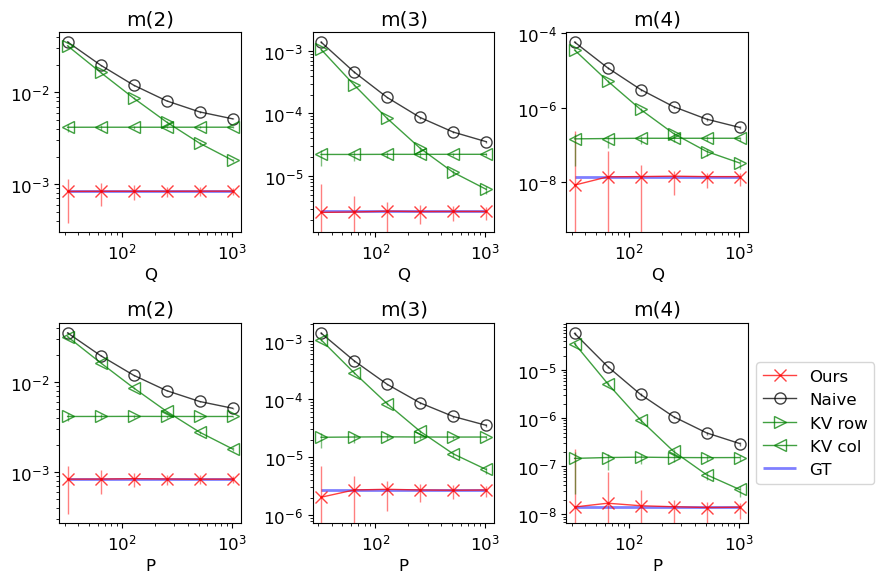

In [118]:

fig,ax=plt.subplots(2,3,figsize=(9,6))

#for i in range(np.shape(Mss_s)[1]):
for i in range(3):
    #ax.plot(Qs,Mss_s[:,i,:])
    xoi=Qs
    
    qoi=Mss_s[:,i,:]#-Mts[i]
    colorv='r'
    zo=10
    yval=np.nanmedian(qoi,axis=1)
    lower_error=np.nanquantile(qoi,axis=1,q=0.25)
    upper_error=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower_error, upper_error-yval]
    ax[0][i].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=0.5,lw=1,zorder=zo)#, fmt='o')
    yval=np.nanmean(qoi,axis=1)
    ax[0][i].plot(xoi, yval,c=colorv,marker='x',fillstyle='none',ls='-',alpha=0.75,ms=8,lw=1,label=r'Ours',zorder=zo*100)#, fmt='o')

    
    qoi=Mns_s[:,i,:]#-Mts[i]
    colorv='k'
    zo=10
    yval=np.nanmedian(qoi,axis=1)
    lower_error=np.nanquantile(qoi,axis=1,q=0.25)
    upper_error=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower_error, upper_error-yval]
    ax[0][i].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=0.5,lw=1,zorder=zo)#, fmt='o')
    yval=np.nanmean(qoi,axis=1)
    ax[0][i].plot(xoi, yval,c=colorv,marker='o',fillstyle='none',ls='-',alpha=0.75,ms=8,lw=1,label=r'Naive',zorder=zo*100)#, fmt='o')

    qoi=Mk0s_s[:,i,:]#-Mts[i]
    colorv='g'
    zo=10
    yval=np.nanmedian(qoi,axis=1)
    lower_error=np.nanquantile(qoi,axis=1,q=0.25)
    upper_error=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower_error, upper_error-yval]
    ax[0][i].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=0.5,lw=1,zorder=zo)#, fmt='o')
    yval=np.nanmean(qoi,axis=1)
    ax[0][i].plot(xoi, yval,c=colorv,marker='>',fillstyle='none',ls='-',alpha=0.75,ms=8,lw=1,label=r'KV row',zorder=zo*100)#, fmt='o')

    qoi=Mk1s_s[:,i,:]#-Mts[i]
    colorv='g'
    zo=10
    yval=np.nanmedian(qoi,axis=1)
    lower_error=np.nanquantile(qoi,axis=1,q=0.25)
    upper_error=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower_error, upper_error-yval]
    ax[0][i].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=0.5,lw=1,zorder=zo)#, fmt='o')
    yval=np.nanmean(qoi,axis=1)
    ax[0][i].plot(xoi, yval,c=colorv,marker='<',fillstyle='none',ls='-',alpha=0.75,ms=8,lw=1,label=r'KV col',zorder=zo*100)#, fmt='o')
  
    
    ax[0][i].hlines(Mts[i],np.min(Qs),np.max(Qs),color='b',alpha=0.5,lw=2,label='GT')
    ax[0][i].set_xscale('log')
    ax[0][i].set_yscale('log')
    ax[0][i].set_xlabel('Q')
    ax[0][i].set_title('m({})'.format(i+2))
    
    ###############################################################
    
    xoi=Ps
    
    qoi=Mss2_s[:,i,:]#-Mts[i]
    colorv='r'
    zo=10
    yval=np.nanmedian(qoi,axis=1)
    lower_error=np.nanquantile(qoi,axis=1,q=0.25)
    upper_error=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower_error, upper_error-yval]
    ax[1][i].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=0.5,lw=1,zorder=zo)#, fmt='o')
    yval=np.nanmean(qoi,axis=1)
    ax[1][i].plot(xoi, yval,c=colorv,marker='x',fillstyle='none',ls='-',alpha=0.75,ms=8,lw=1,label=r'Ours',zorder=zo*100)#, fmt='o')

    
    qoi=Mns2_s[:,i,:]#-Mts[i]
    colorv='k'
    zo=10
    yval=np.nanmedian(qoi,axis=1)
    lower_error=np.nanquantile(qoi,axis=1,q=0.25)
    upper_error=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower_error, upper_error-yval]
    ax[1][i].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=0.5,lw=1,zorder=zo)#, fmt='o')
    yval=np.nanmean(qoi,axis=1)
    ax[1][i].plot(xoi, yval,c=colorv,marker='o',fillstyle='none',ls='-',alpha=0.75,ms=8,lw=1,label=r'Naive',zorder=zo*100)#, fmt='o')

    qoi=Mk0s2_s[:,i,:]#-Mts[i]
    colorv='g'
    zo=10
    yval=np.nanmedian(qoi,axis=1)
    lower_error=np.nanquantile(qoi,axis=1,q=0.25)
    upper_error=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower_error, upper_error-yval]
    ax[1][i].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=0.5,lw=1,zorder=zo)#, fmt='o')
    yval=np.nanmean(qoi,axis=1)
    ax[1][i].plot(xoi, yval,c=colorv,marker='>',fillstyle='none',ls='-',alpha=0.75,ms=8,lw=1,label=r'KV row',zorder=zo*100)#, fmt='o')

    qoi=Mk1s2_s[:,i,:]#-Mts[i]
    colorv='g'
    zo=10
    yval=np.nanmedian(qoi,axis=1)
    lower_error=np.nanquantile(qoi,axis=1,q=0.25)
    upper_error=np.nanquantile(qoi,axis=1,q=0.75)
    asymmetric_error = [yval-lower_error, upper_error-yval]
    ax[1][i].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=0.5,lw=1,zorder=zo)#, fmt='o')
    yval=np.nanmean(qoi,axis=1)
    ax[1][i].plot(xoi, yval,c=colorv,marker='<',fillstyle='none',ls='-',alpha=0.75,ms=8,lw=1,label=r'KV col',zorder=zo*100)#, fmt='o')
  
    
    ax[1][i].hlines(Mts[i],np.min(Ps),np.max(Ps),color='b',alpha=0.5,lw=2,label='GT')
    ax[1][i].set_xscale('log')
    ax[1][i].set_yscale('log')
    ax[1][i].set_xlabel('P')
    ax[1][i].set_title('m({})'.format(i+2))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()



In [10]:
np.savez('RBF_plot_data.npz', 
         kmax=kmax, seed=seed, sigmax=sigmax, 
         Ps=Ps, Qs=Qs, 
         P=P, Q=Q, sigma=sigma, d=d, 
         Mss=Mss, Mns=Mns, Mk0s=Mk0s, Mk1s=Mk1s,
         Mss_s=Mss_s, Mns_s=Mns_s, Mk0s_s=Mk0s_s, Mk1s_s=Mk1s_s,
         Mss2_s=Mss2_s, Mns2_s=Mns2_s, Mk0s2_s=Mk0s2_s, Mk1s2_s=Mk1s2_s,
         Mts=Mts)





In [ ]:
#### Error analysis


numit=30

seed=2

P=300
#Q=600
Qs=np.power(10,np.linspace(np.log10(10),np.log10(1000),10)).astype(int)
#Qs=np.power(10,np.linspace(np.log10(300),np.log10(4000),5)).astype(int)

repss=[1,2,6,24]

Mss_ss=[]
Mns_ss=[]
Mk0s_ss=[]
Mk1s_ss=[]

for reps in repss:
    Mss_s=[]
    Mns_s=[]
    Mk0s_s=[]
    Mk1s_s=[]

    for Q in Qs:
        print('')
        print(Q)
        Mss,Mns,Mk0s,Mk1s,dimest,gams = run_repeats(P,Q,d,sigma,sigmax,eps_a,eps_m,kmax,seed,numit,noAlt,reps=reps)

        Mss_s.append(Mss)
        Mns_s.append(Mns)
        Mk0s_s.append(Mk0s)
        Mk1s_s.append(Mk1s)

    Mss_ss.append(Mss_s)
    Mns_ss.append(Mns_s)
    Mk0s_ss.append(Mk0s_s)
    Mk1s_ss.append(Mk1s_s)

Mss_ss=np.array(Mss_ss)
Mns_ss=np.array(Mns_ss)
Mk0s_ss=np.array(Mk0s_ss)
Mk1s_ss=np.array(Mk1s_ss)

Sigma_x=jnp.eye(d)*sigmax**2
Sigma=jnp.eye(d)*sigma**2

Mts=[]
for k in np.arange(1,kmax)+1:
    Mts.append(compute_RBF_m(k, Sigma, Sigma_x))
    
Mts=np.array(Mts)



###########################################################################################################
###########################################################################################################
###########################################################################################################
###########################################################################################################


showOthers=False

color = plt.cm.rainbow(np.linspace(0, 1, len(repss)))

fig,ax=plt.subplots(1,1,figsize=(5,3))
#ax.plot(Ps,gims,c='k',label='theory')

for j in range(len(repss)):
    for i in range(kmax-1):
        #i=2
        xoi=Qs

        gt=Mts[i]

        #xoi=np.arange(kmax-1)+2
        qoi=Mss_ss[j,:,i,:]
        yval=np.nanmean(np.square(gt-qoi),axis=1)#/np.square(gt)
        #yval=np.square(np.nanstd(qoi,axis=1))
        
        colorv='r'
        zo=10
        #ax.plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Ours',zorder=zo*100)#, fmt='o')
        ax.plot(xoi, yval,c=color[j],marker='o',ms=2,ls='-',alpha=1,lw=1,label='{}'.format(repss[j]),zorder=zo*100)#, fmt='o')

        if j==0:
            ax.text(xoi[-1],yval[-1],'m({})'.format(i+2),ha='right', va='bottom',fontsize=13)
        if showOthers:
            #xoi=np.arange(kmax-1)+2
            qoi=Mns_ss[j,:,i,:]
            yval=np.nanmean(np.square(gt[:,None]-qoi),axis=1)
            colorv='k'
            zo=5
            ax[0].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Naive',zorder=zo*100)#, fmt='o')

            #xoi=np.arange(kmax-1)+2
            qoi=Mk0s_ss[j,:,i,:]
            yval=np.nanmean(np.square(gt[:,None]-qoi),axis=1)
            colorv='g'
            zo=1
            ax[0].plot(xoi, yval,c=colorv,marker='+',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Kong row',zorder=zo*100)#, fmt='o')

            #xoi=np.arange(kmax-1)+2
            qoi=Mk1s_ss[j,:,i,:]
            yval=np.nanmean(np.square(gt[:,None]-qoi),axis=1)
            colorv='g'
            zo=1
            ax[0].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Kong col',zorder=zo*100)#, fmt='o')



#ax.set_xscale('log')
ax.set_xlabel('Q')
ax.set_ylabel('MSE (~Variance)')

ax.set_title('P={}'.format(P))

ax.set_yscale('log')    
ax.set_xscale('log')


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='center left', bbox_to_anchor=(1, 0.5),title="# of perms:")
fig.tight_layout()


# Plot the estimator as we vary Q (for each moments separately)
# Also show other estimators

# the lowest moment order should be 2
# Also scale P

# permutations: 1,6,24

